# Tutorial: Detec√ß√£o de Linhas de Pista para Carros Aut√¥nomos

Este tutorial demonstra como detectar e analisar linhas de pista usando OpenCV, incluindo:
1. Pr√©-processamento da imagem
2. Detec√ß√£o de bordas com Canny
3. Transformada de Hough para detec√ß√£o de linhas
4. Regi√£o de interesse
5. Transforma√ß√£o de perspectiva (Bird's Eye View)
6. An√°lise de curvatura das linhas

## 1. Importa√ß√£o das Bibliotecas e Carregamento da Imagem

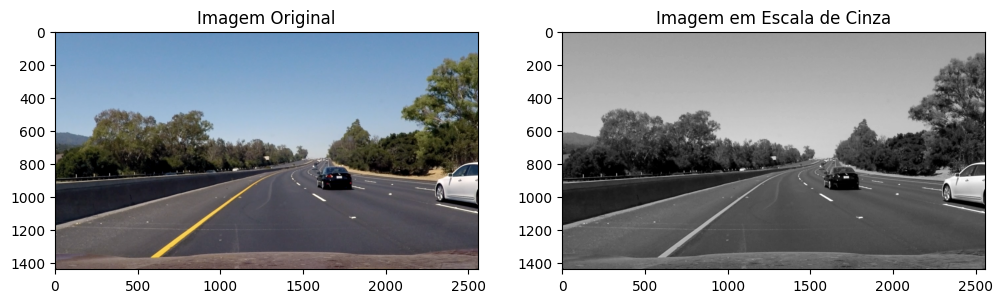

In [23]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Carrega e converte a imagem
img = cv2.imread('lab_images/estrada.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Converte para escala de cinza
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Exibe a imagem original
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Imagem Original')
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap='gray')
plt.title('Imagem em Escala de Cinza')
plt.show()

## 2. Detec√ß√£o de Bordas com Algoritmo de Canny

O algoritmo de Canny detecta bordas na imagem, que s√£o essenciais para encontrar as linhas da pista.

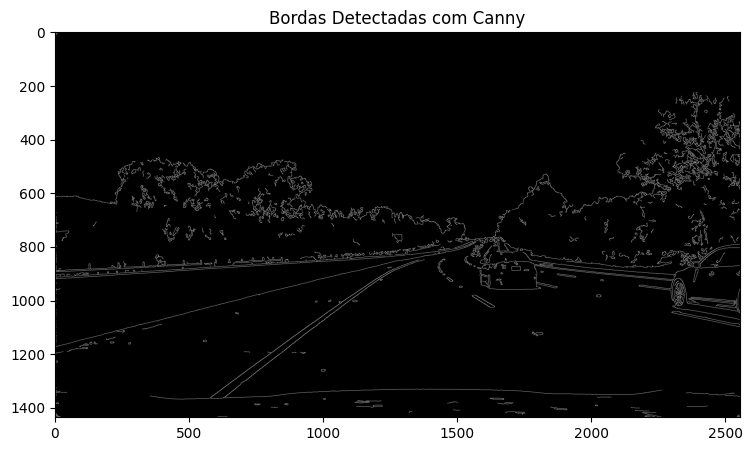

In [24]:
# Aplica o detector de bordas Canny
# Par√¢metros: imagem, threshold_baixo, threshold_alto
edges = cv2.Canny(img_gray, 50, 150)

plt.figure(figsize=(10, 5))
plt.imshow(edges, cmap='gray')
plt.title('Bordas Detectadas com Canny')
plt.show()

## 3. Aplica√ß√£o da Regi√£o de Interesse

Focamos apenas na √°rea da estrada onde esperamos encontrar as linhas da pista.

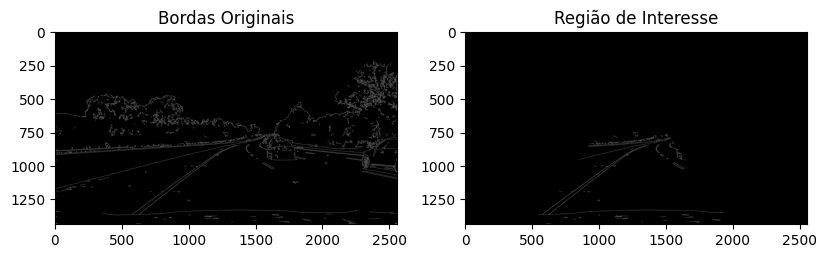

In [29]:
# Fun√ß√£o para isolar a regi√£o de interesse
def region_of_interest(img):
    """
    Aplica uma m√°scara para focar apenas na regi√£o onde as linhas da pista
    normalmente aparecem (parte inferior da imagem em formato trapezoidal)
    """
    mask = np.zeros_like(img)
    height, width = img.shape[:2]
    
    # Define um pol√≠gono trapezoidal na parte inferior da imagem
    polygon = np.array([
        [(500, height), (2000, height), (1500, 750), (1000, 750)]
    ], dtype=np.int32)
    
    cv2.fillPoly(mask, polygon, (255, 255, 255))
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img

# Aplica a regi√£o de interesse
roi_edges = region_of_interest(edges)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Bordas Originais')
plt.subplot(1, 3, 2)
plt.imshow(roi_edges, cmap='gray')
plt.title('Regi√£o de Interesse')
plt.show()

## 4. Detec√ß√£o de Linhas com Transformada de Hough

A Transformada de Hough Probabil√≠stica detecta linhas retas na imagem.

Linhas detectadas: 75


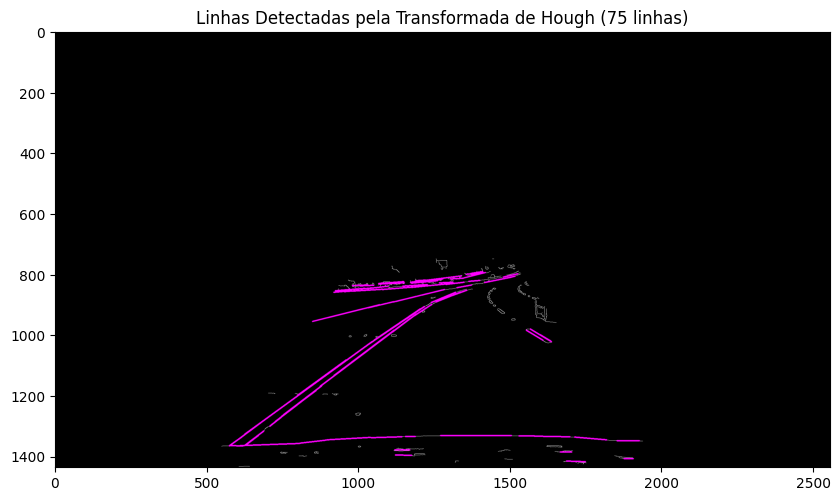

In [30]:
# Aplica a Transformada de Hough para detectar linhas
lines = cv2.HoughLinesP(
    roi_edges,           # Imagem com bordas
    1,                   # Resolu√ß√£o de dist√¢ncia em pixels
    np.pi/180,          # Resolu√ß√£o angular em radianos
    50,                 # Threshold m√≠nimo de votos
    minLineLength=30,   # Comprimento m√≠nimo da linha
    maxLineGap=10       # Gap m√°ximo entre segmentos de linha
)

# Cria uma c√≥pia da imagem para desenhar as linhas
hough_img_rgb = cv2.cvtColor(roi_edges, cv2.COLOR_GRAY2BGR)

print(f"Linhas detectadas: {len(lines)}")

# Desenha todas as linhas detectadas
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(hough_img_rgb, (x1, y1), (x2, y2), (255, 0, 255), 3)

plt.figure(figsize=(10, 8))
plt.imshow(hough_img_rgb)
plt.title(f'Linhas Detectadas pela Transformada de Hough ({len(lines)} linhas)')
plt.show()

## 5. Transforma√ß√£o de Perspectiva (Bird's Eye View)

Convertemos a perspectiva da c√¢mera para uma vista a√©rea, facilitando a an√°lise das linhas.

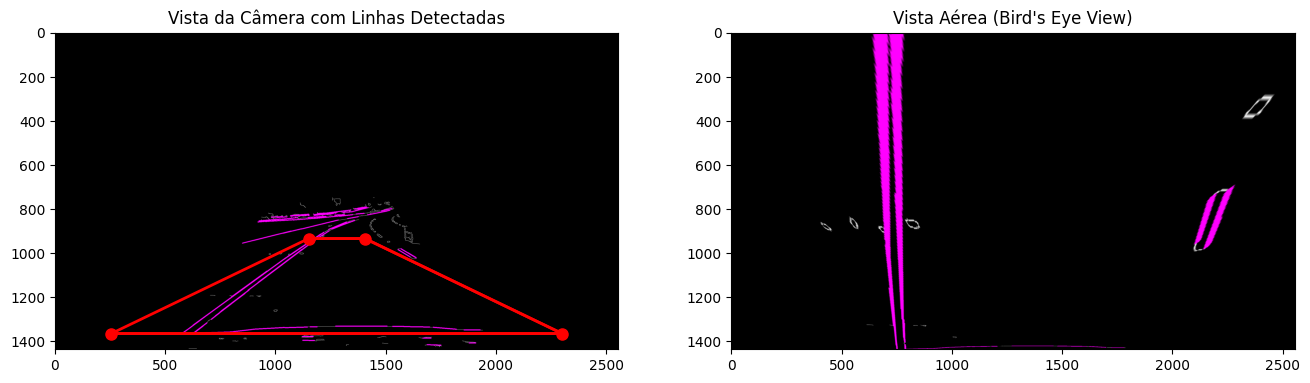

In [31]:
# Altura e largura da imagem
h, w = img.shape[:2]

# Pontos de origem na perspectiva da c√¢mera (ajuste conforme necess√°rio)
src = np.float32([
    [w * 0.45, h * 0.65],  # topo esquerdo
    [w * 0.55, h * 0.65],  # topo direito
    [w * 0.9, h * 0.95],   # base direita
    [w * 0.1, h * 0.95]    # base esquerda
])

# Pontos de destino para formar um ret√¢ngulo (vista a√©rea)
dst = np.float32([
    [w * 0.2, 0],      # topo esquerdo
    [w * 0.8, 0],      # topo direito
    [w * 0.8, h],      # base direita
    [w * 0.2, h]       # base esquerda
])

# Calcula a matriz de transforma√ß√£o de perspectiva
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(hough_img_rgb, M, (w, h))

# Exibe os resultados
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.imshow(hough_img_rgb)
plt.title('Vista da C√¢mera com Linhas Detectadas')
plt.plot(*zip(*src), marker='o', color='red', markersize=8, linewidth=2)
plt.plot([src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]], 
         [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]], 'r-', linewidth=2)

plt.subplot(1, 2, 2)
plt.imshow(warped)
plt.title('Vista A√©rea (Bird\'s Eye View)')
plt.show()

## 6. An√°lise das Linhas: Reta vs Curva

Agora vamos analisar as linhas detectadas para determinar se representam uma estrada reta ou com curvas.

In [32]:
def analyze_lines(lines, img_shape):
    """
    Analisa as linhas detectadas para determinar se formam uma trajet√≥ria reta ou curva
    """
    if lines is None or len(lines) == 0:
        return "Nenhuma linha detectada", 0, []
    
    # Separa linhas por lado (esquerda e direita) baseado na posi√ß√£o x
    left_lines = []
    right_lines = []
    center_x = img_shape[1] // 2
    
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Calcula a inclina√ß√£o da linha
        if x2 - x1 != 0:
            slope = (y2 - y1) / (x2 - x1)
            
            # Classifica como linha esquerda ou direita baseado na posi√ß√£o e inclina√ß√£o
            if x1 < center_x and slope < 0:  # Linha esquerda (inclina√ß√£o negativa)
                left_lines.append((slope, x1, y1, x2, y2))
            elif x1 > center_x and slope > 0:  # Linha direita (inclina√ß√£o positiva)
                right_lines.append((slope, x1, y1, x2, y2))
    
    # Calcula a varia√ß√£o das inclina√ß√µes
    all_slopes = []
    if left_lines:
        all_slopes.extend([line[0] for line in left_lines])
    if right_lines:
        all_slopes.extend([line[0] for line in right_lines])
    
    if not all_slopes:
        return "Linhas insuficientes para an√°lise", 0, []
    
    # Calcula a varia√ß√£o das inclina√ß√µes
    slope_variation = np.std(all_slopes)
    avg_slope = np.mean(np.abs(all_slopes))
    
    # Determina se √© reta ou curva baseado na varia√ß√£o
    if slope_variation < 0.3 and avg_slope < 0.5:
        road_type = "ESTRADA RETA"
    elif slope_variation < 0.5:
        road_type = "CURVA SUAVE"
    else:
        road_type = "CURVA ACENTUADA"
    
    return road_type, slope_variation, all_slopes

# Analisa as linhas detectadas
road_analysis, variation, slopes = analyze_lines(lines, img.shape)

print("="*50)
print("AN√ÅLISE DA TRAJET√ìRIA DA ESTRADA")
print("="*50)
print(f"Tipo de estrada: {road_analysis}")
print(f"Varia√ß√£o das inclina√ß√µes: {variation:.3f}")
print(f"N√∫mero total de linhas: {len(lines)}")
print(f"Inclina√ß√µes m√©dias: {np.mean(np.abs(slopes)):.3f}")
print("="*50)

# Classifica√ß√£o adicional
if variation < 0.2:
    print("‚úÖ Estrada muito reta - Ideal para velocidade alta")
elif variation < 0.4:
    print("‚ö†Ô∏è  Estrada com curvas leves - Velocidade moderada recomendada")
else:
    print("üö® Estrada com curvas acentuadas - Reduzir velocidade")

AN√ÅLISE DA TRAJET√ìRIA DA ESTRADA
Tipo de estrada: CURVA SUAVE
Varia√ß√£o das inclina√ß√µes: 0.365
N√∫mero total de linhas: 75
Inclina√ß√µes m√©dias: 0.325
‚ö†Ô∏è  Estrada com curvas leves - Velocidade moderada recomendada


## 7. Visualiza√ß√£o Final Comparativa

Compara√ß√£o entre a detec√ß√£o original e a vista a√©rea para melhor compreens√£o.

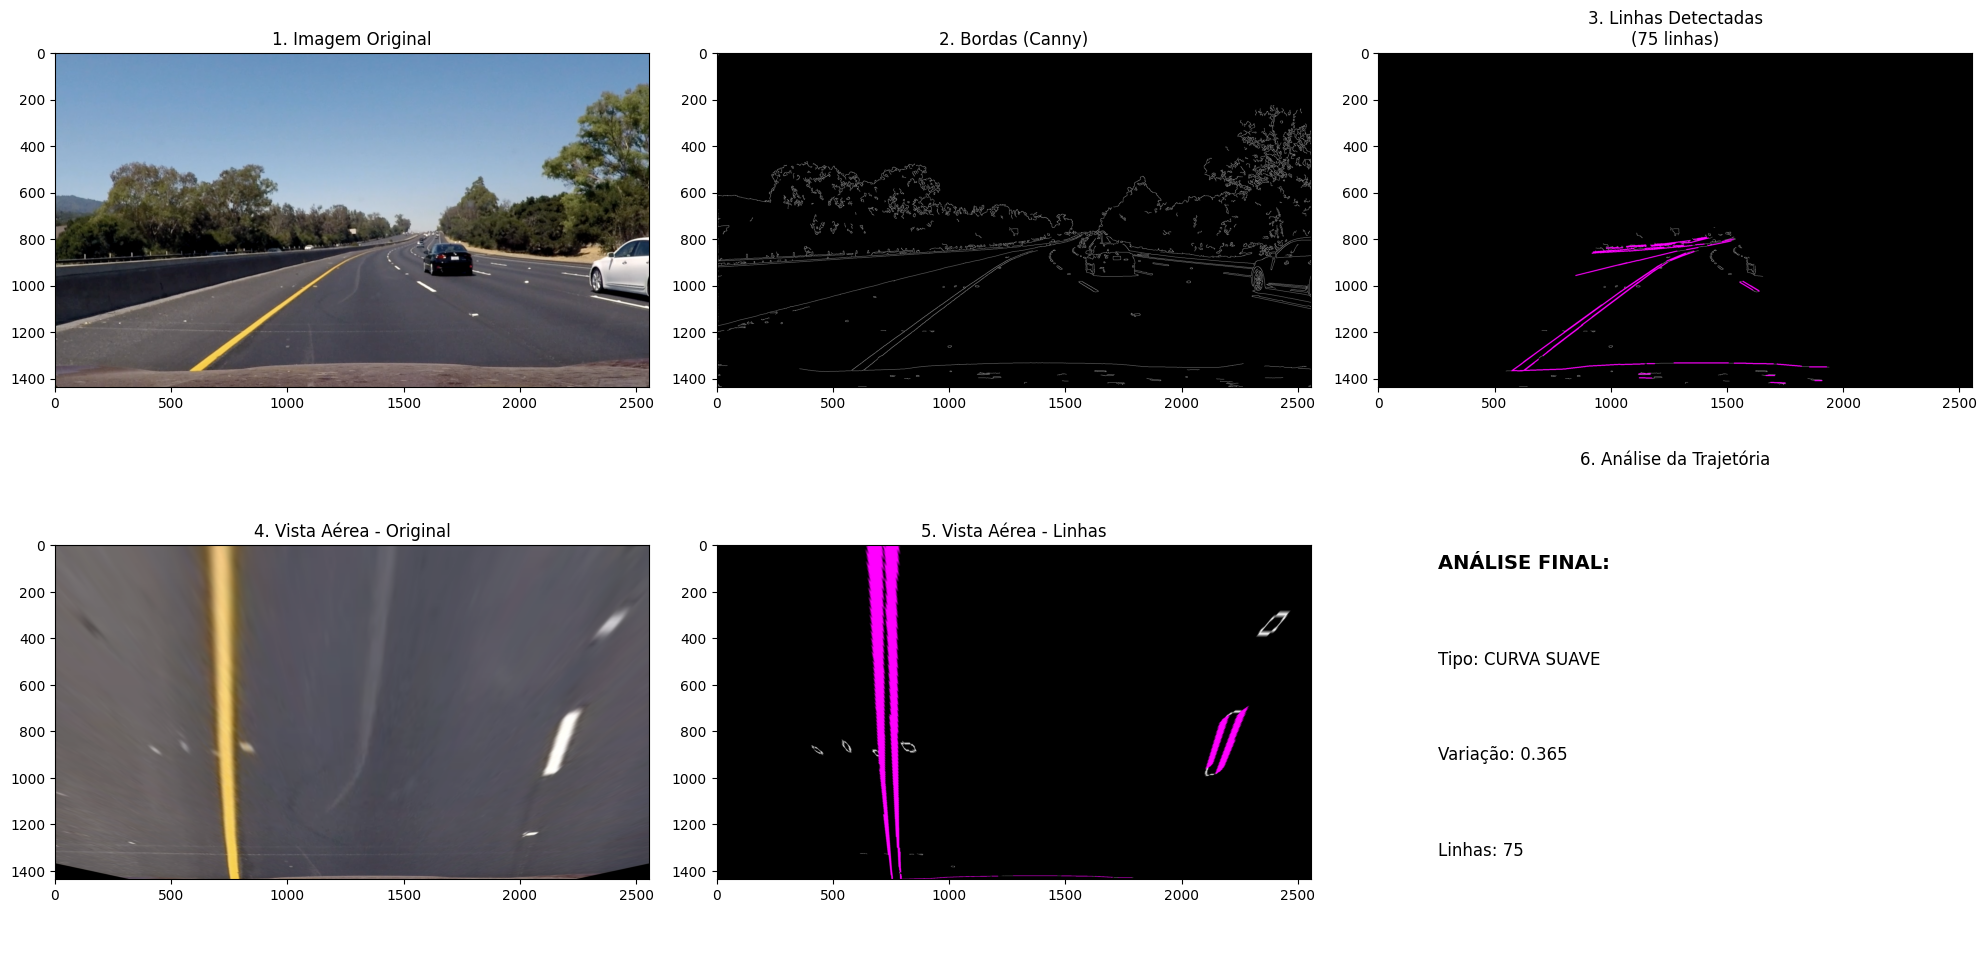

In [34]:
# Aplica a transforma√ß√£o na imagem original para compara√ß√£o
warped_original = cv2.warpPerspective(img, M, (w, h))

plt.figure(figsize=(20, 10))

# Imagem original
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('1. Imagem Original')

# Bordas detectadas
plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('2. Bordas (Canny)')

# Linhas detectadas na vista da c√¢mera
plt.subplot(2, 3, 3)
plt.imshow(hough_img_rgb)
plt.title(f'3. Linhas Detectadas\n({len(lines)} linhas)')

# Imagem original em vista a√©rea
plt.subplot(2, 3, 4)
plt.imshow(warped_original)
plt.title('4. Vista A√©rea - Original')

# Linhas em vista a√©rea
plt.subplot(2, 3, 5)
plt.imshow(warped)
plt.title('5. Vista A√©rea - Linhas')

# An√°lise final
plt.subplot(2, 3, 6)
plt.text(0.1, 0.8, f'AN√ÅLISE FINAL:', fontsize=14, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f'Tipo: {road_analysis}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.4, f'Varia√ß√£o: {variation:.3f}', fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.2, f'Linhas: {len(lines)}', fontsize=12, transform=plt.gca().transAxes)
plt.axis('off')
plt.title('6. An√°lise da Trajet√≥ria')

plt.tight_layout()
plt.show()
